In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
!pip install tensorflow_addons

In [3]:
import tensorflow as tf
#tf.config.experimental.set_visible_devices([], 'GPU')

import tensorflow_addons as tfa
import glob
import concurrent.futures

from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow_datasets as tfds
tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
train_A_paths = glob.glob('summer2winter/trainA/*.jpg')
train_B_paths = glob.glob('summer2winter/trainB/*.jpg')
print('Train summer：',len(train_A_paths))
print('Train winter：',len(train_B_paths))

Train summer： 1231
Train winter： 962


In [5]:
test_A_paths = glob.glob('summer2winter/testA/*.jpg')
test_B_paths = glob.glob('summer2winter/testB/*.jpg')
print('Test summer：',len(test_A_paths))
print('Test winter：',len(test_B_paths))

Test summer： 309
Test winter： 238


In [6]:
IMGSIZE = 256
def read_img(image):
    img = tf.keras.preprocessing.image.load_img(image, color_mode='rgb', target_size=(IMGSIZE, IMGSIZE))
    return img
def prepare_dataset(namelist):
    start = time.time()
    imgs = []
    with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
        i = 0
        for value in executor.map(read_img, namelist):
            i+=1
            print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
            imgs.append(value)
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
    print("\nExecution time: ",time.time() - start, "s")
    return imgs

In [7]:
with tf.device('/gpu:0'):
    train_a= prepare_dataset(train_A_paths)
    train_b= prepare_dataset(train_B_paths)
    test_a= prepare_dataset(test_A_paths)
    test_b= prepare_dataset(test_B_paths)
print("Training A tensor shape", train_a.shape)
print("Training B tensor shape", train_b.shape)
print("Testing A tensor shape", test_a.shape)
print("Testing B tensor shape", test_b.shape)

Fetching: [1231/1231]
Execution time:  4.034210205078125 s
Fetching: [962/962]
Execution time:  3.0358781814575195 s
Fetching: [309/309]
Execution time:  0.9594323635101318 s
Fetching: [238/238]
Execution time:  0.8648838996887207 s
Training A tensor shape (1231, 256, 256, 3)
Training B tensor shape (962, 256, 256, 3)
Testing A tensor shape (309, 256, 256, 3)
Testing B tensor shape (238, 256, 256, 3)


In [8]:
def map(image):

    image = tf.cast(image, tf.float32)
    image = image / 255
    image = image * 2 - 1
    
    return image

In [9]:
train_a = tf.data.Dataset.from_tensor_slices(train_a)
train_b = tf.data.Dataset.from_tensor_slices(train_b)
test_a = tf.data.Dataset.from_tensor_slices(test_a)
test_b = tf.data.Dataset.from_tensor_slices(test_b)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 200

train_a = train_a.map(map, 
                      num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
train_b = train_b.map(map, 
                      num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_a = test_a.map(map, 
                      num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_b = test_b.map(map, 
                      num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)

train_dataset = tf.data.Dataset.zip((train_a, train_b))
test_dataset = tf.data.Dataset.zip((test_a, test_b))

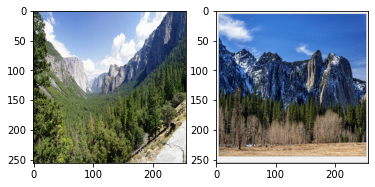

In [11]:
plt.figure(figsize=(6, 3))
for imgs_A, imgs_B in test_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow((imgs_A[0]+1)/2)
    plt.subplot(1,2,2)
    plt.imshow((imgs_B[0]+1)/2)

In [12]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [26]:
for example_input, example_target in test_dataset.take(10):
    pass

In [27]:
def image_show():
    
    title=['Source domain','Target domain','Map']
    rendered_pictures = generator_g(example_input, training=False)
    rendered_picture = rendered_pictures[0]
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,3,1)
    plt.imshow((example_input[0].numpy()+1)/2)
    plt.title(title[0])
    plt.subplot(1,3,2)
    plt.imshow((example_target[0].numpy()+1)/2)       
    plt.title(title[1])
    plt.subplot(1,3,3)
    plt.imshow((rendered_picture.numpy()+1)/2)
    plt.title(title[2])
    plt.show()
    
    return rendered_pictures

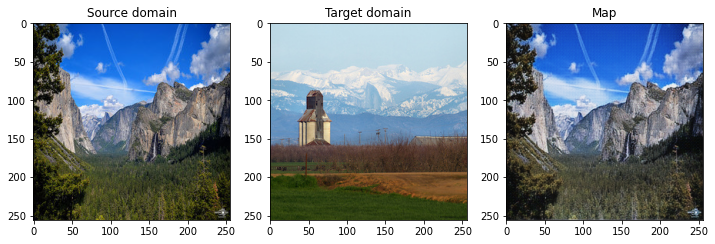

In [28]:
pred = image_show()

In [16]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [18]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [19]:
@tf.function
def train_discriminator(image_a, image_b):
    with tf.GradientTape(persistent=True) as discriminator_tape:
        #A->B->A
        fake_b = generator_g(image_a, training=True)
        cycled_a = generator_f(fake_b, training=True)
        #B->A->B
        fake_a = generator_f(image_b, training=True)
        cycled_b = generator_g(fake_a, training=True)
        #discriminator
        disc_real_a = discriminator_x(image_a, training=True)
        disc_real_b = discriminator_y(image_b, training=True)
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        discriminator_x_loss = discriminator_loss(disc_real_a, disc_fake_a)
        discriminator_y_loss = discriminator_loss(disc_real_b, disc_fake_b)
        
    discriminator_x_gradients = discriminator_tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = discriminator_tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

@tf.function
def train_generator(image_a, image_b):
    with tf.GradientTape(persistent=True) as generator_tape:
        #A->B->A
        fake_b = generator_g(image_a, training=True)
        cycled_a = generator_f(fake_b, training=True)
        #B->A->B
        fake_a = generator_f(image_b, training=True)
        cycled_b = generator_g(fake_a, training=True)
        #discriminator
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        gen_x_loss = generator_loss(disc_fake_b)
        gen_y_loss = generator_loss(disc_fake_a)
        
        total_cycle_loss = calc_cycle_loss(image_a, cycled_a) + calc_cycle_loss(image_b, cycled_b)
        
        total_gen_x_loss = gen_x_loss + total_cycle_loss
        total_gen_y_loss = gen_y_loss + total_cycle_loss
        
    generator_g_gradients = generator_tape.gradient(total_gen_x_loss, generator_g.trainable_variables)
    generator_f_gradients = generator_tape.gradient(total_gen_y_loss, generator_f.trainable_variables)
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))




Epoch 1/15 
Training: [--------->] 100 %  - 2172 s

Epoch 2/15 
Training: [--------->] 100 %  - 1244 s

Epoch 3/15 
Training: [--------->] 100 %  - 1245 s

Epoch 4/15 
Training: [--------->] 100 %  - 1245 s

Epoch 5/15 
Training: [--------->] 100 %  - 1245 s


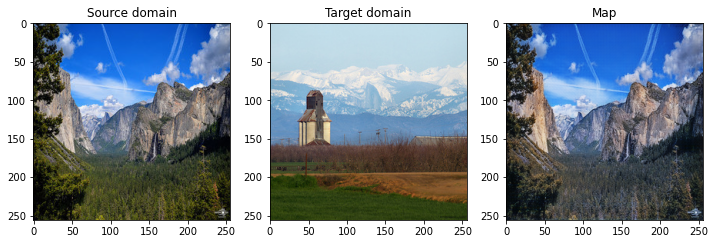


Epoch 6/15 
Training: [--------->] 100 %  - 1244 s

Epoch 7/15 
Training: [--------->] 100 %  - 1244 s

Epoch 8/15 
Training: [--------->] 100 %  - 1244 s

Epoch 9/15 
Training: [--------->] 100 %  - 1244 s

Epoch 10/15 
Training: [--------->] 100 %  - 1245 s


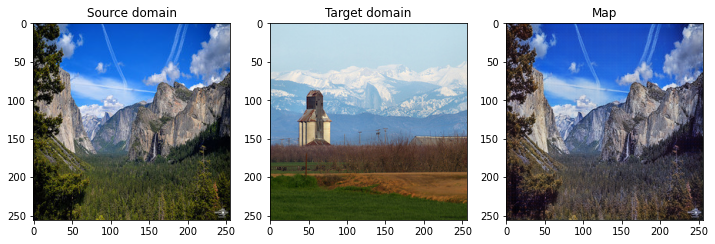


Epoch 11/15 
Training: [--------->] 100 %  - 1245 s

Epoch 12/15 
Training: [--------->] 100 %  - 1245 s

Epoch 13/15 
Training: [--------->] 100 %  - 1244 s

Epoch 14/15 
Training: [--------->] 100 %  - 1245 s

Epoch 15/15 
Training: [--------->] 100 %  - 1245 s


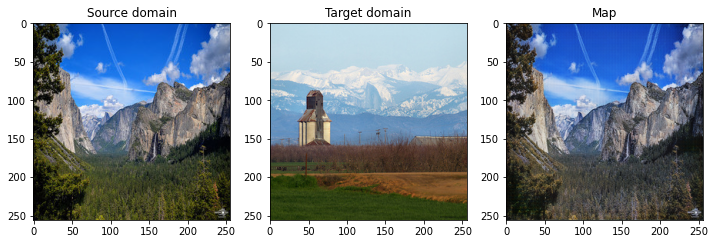

In [32]:
Epochs = 15

for epoch in range(Epochs):
    start = time.time()
    i = 0
    print ('\nEpoch {}/{} '.format(epoch+1, Epochs))
    for img_a, img_b in train_dataset:
        
        train_discriminator(img_a, img_b)
        train_generator(img_a, img_b)
        
        percent = float(i+1) * 100 / len(train_dataset)
        arrow   = '-' * int(percent/100 * 10 - 1) + '>'
        spaces  = ' ' * (10 - len(arrow))
        print('\rTraining: [%s%s] %d %% '% (arrow, spaces, percent), end='', flush=True)
        i += 1
    print(" -", int(time.time()-start), "s", end="")
    print()
    
    if (epoch+1)%5==0:
        cache = image_show()

In [22]:
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

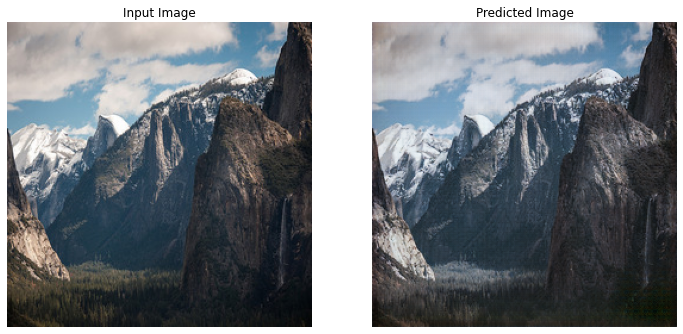

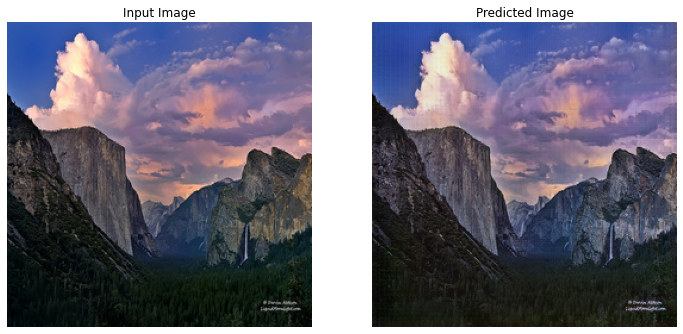

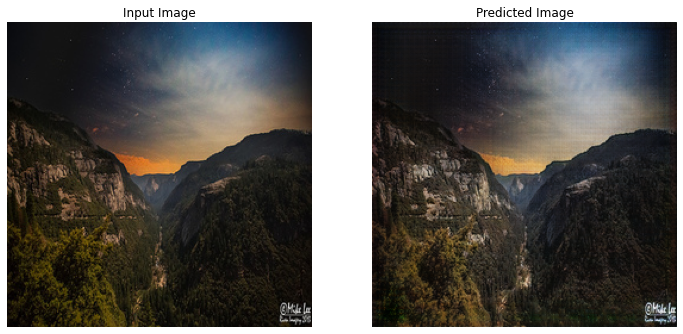

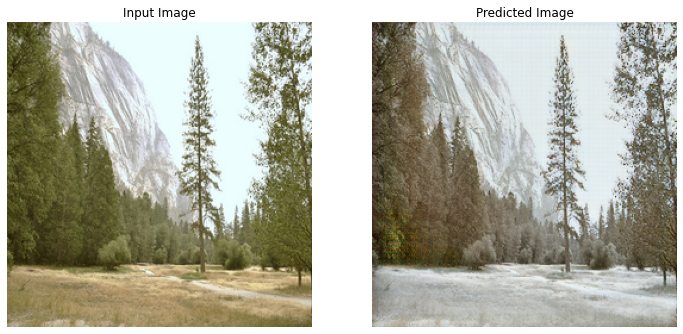

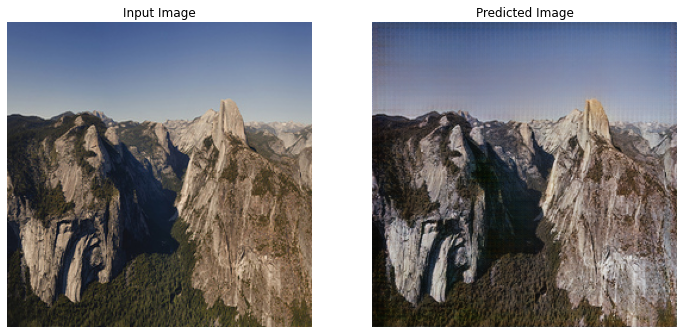

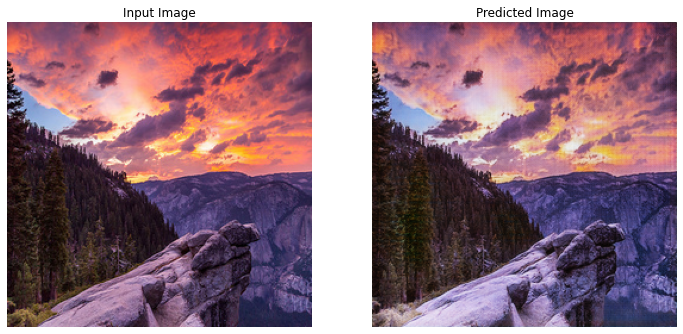

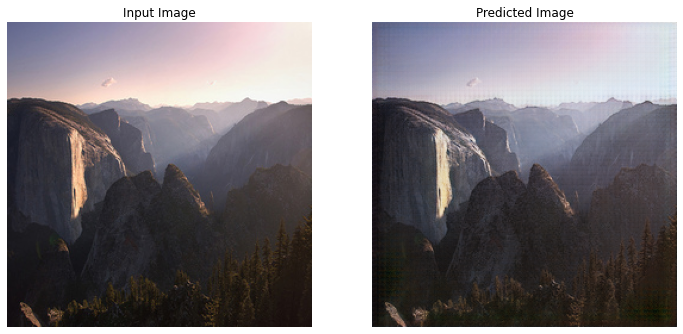

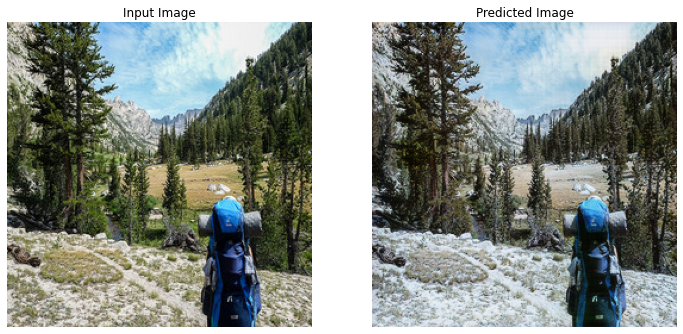

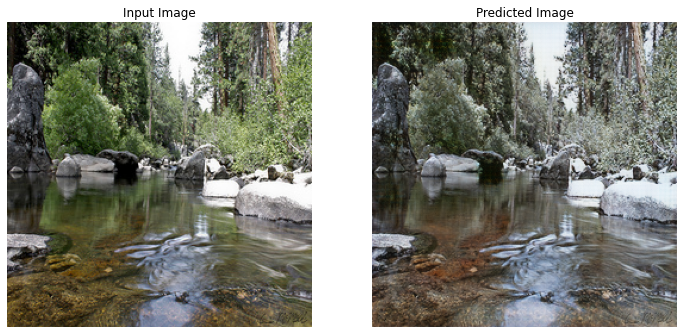

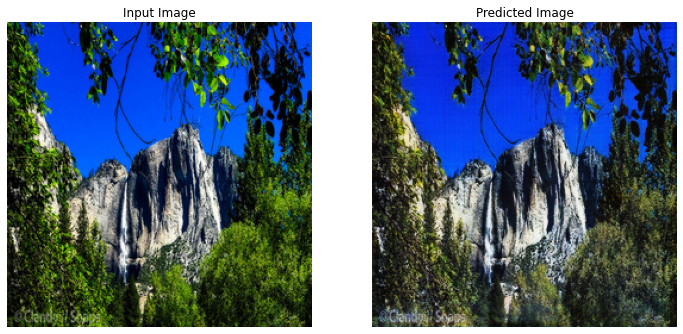

In [37]:
# Run the trained model on the test dataset
for inp in test_dataset.take(10):
    generate_images(generator_g, inp[0])